## Lichen fractional cover statistics 
## Prepares labelled input for the Machine Learning algorithm for **year 2019**
## (i.e. locations where moss&lichen fractional cover changes can be related to meteorological parameters from ERA5-Land)

# ESA WorldCover **2020**
## Two versions of the WorldCover products are available:
 * WorldCover 2020 produced using v100 of the algorithm
 * WorldCover 2021 produced using v200 of the algorithm
#### Since the WorldCover maps for 2020 and 2021 were generated with different algorithm versions (v100 and v200, respectively), changes between the maps include both changes in real land cover and changes due to the used algorithms.

### The ESA WorldCover products are delivered in 3x3 degree tiles as Cloud Optimized GeoTIFFs (COGs) in EPSG:4326 projection (geographic latitude/longitude CRS). There are 2651 tiles.
### Each tile contains 2 data layers:
 * Map: Land cover map with 11 classes, a total of approximately 117 GB
 * InputQuality: Three band GeoTIFF providing three per pixel quality indicators of the Sentinel-1 and Sentinel-2 input data 


## Data download 
### The relevant tiles were downloaded using the WorldCover viewer (https://viewer.esa-worldcover.org/worldcover/) as a .zip file containing two rows for latitudes 66 & 69N, and the Map.tif are stored in a local folder

# Calculate fractional cover, one tile at a time, and saves partial results into hdf5

In [1]:
#!pip install tables

In [2]:
!date

Fri Mar 24 20:20:13 CET 2023


In [3]:
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio
import xarray as xr
import vaex

# Local path for ERA5-land and ESA WorldCover data

In [4]:
path = '/opt/uio/data/'

# ERA5-land data from **local** netCDF file

In [5]:
# ERA5-land data already available as a netCDF file stored locally
ERA5_filename = os.path.join(path, 'reanalysis-era5-land_hourly_2015-01-01_2022-12-31_Troms-Finnmark_T2m-SD-TP.nc')
ERA5land = xr.open_dataset(ERA5_filename, engine = 'netcdf4')

In [6]:
ERA5land

<xarray.Dataset>
Dimensions:    (longitude: 155, latitude: 29, time: 70128, expver: 2)
Coordinates:
  * longitude  (longitude) float32 15.59 15.69 15.79 15.89 ... 30.79 30.89 30.99
  * latitude   (latitude) float32 71.15 71.05 70.95 70.85 ... 68.55 68.45 68.35
  * time       (time) datetime64[ns] 2015-01-01 ... 2022-12-31T23:00:00
  * expver     (expver) int32 1 5
Data variables:
    sd         (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude, expver) float32 ...
    tp         (time, latitude, longitude, expver) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-31 20:28:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [7]:
tile_list = glob.glob(f"{path}/*N*.tif")
tile_list.sort()
tile_list

['/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E015_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E018_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E021_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E024_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E027_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E030_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E015_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E018_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E021_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E024_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E027_Map.tif',
 '/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E030_Map.tif']

In [8]:
for tile in tile_list:
    print(tile)
    output_filename = os.path.join(path, 'Ny_' + tile.split("/")[4].split("_")[5] + '.csv')
    EWC = xr.open_rasterio(tile)
    EWC = EWC.rename(x='lon', y='lat')
    EWC = EWC.isel(band = 0)
# Select only pixels with lichen inside the ERA5-land grid
    dg = xr.where((EWC.lon >= 15.59) & 
                  (EWC.lon <= 30.99) &
                  (EWC.lat >= 68.35) &
                  (EWC.lat <= 71.15) &
                  (EWC == 100), 1, np.nan) 
    print('After cleaning values outside the ERA5-land grid')
    del EWC
    dg = dg.to_dataframe(name = 'New_lichen')
    dg = dg.drop(columns=['band'])
    dg = dg.dropna()
    dg = dg.reset_index()
# Convert to VAEX
    dvy = vaex.from_pandas(dg)
# Find the correspondind ERA5-land lat-lon
# Careful with the latitude, in reverse order
    dvy['ERA5_lon_index'] = ((dvy.lon - 15.59) / 0.1).astype('int').values  
    dvy['ERA5_lat_index'] = 28 - ((dvy.lat - 68.35) / 0.1).astype('int').values 
# Adding columns with the ERA5-land longitude and latitude to dvy    
    dvy['ERA5_lon'] = ERA5land.sel(time="2015-01-01").longitude[dvy['ERA5_lon_index'].values].values
    dvy['ERA5_lat'] = ERA5land.sel(time="2015-01-01").latitude[dvy['ERA5_lat_index'].values].values
# Add combined lon_lat column
    dvy['lon_lat'] = (dvy['ERA5_lon'] * 100).astype('int') + (dvy['ERA5_lat'] * 100).astype('int') / 100000 
    dvy = dvy.drop(columns=['lat', 'lon', 'ERA5_lon_index', 'ERA5_lat_index', 'ERA5_lon', 'ERA5_lat'])
# Count the number of pixels with lichen per ERA5 grid cell
    Ny = dvy.groupby(['lon_lat']).agg('count')
    del dvy
# Convert to lichen fractional cover
    Ny['count'] = Ny['count'] / (12000 * 12000)
    Ny.rename('count', 'Lichen_FC')
## Save into **local** .csv file
    print(output_filename)
    Ny.export_csv(output_filename)

/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E015_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N66E015.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E018_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N66E018.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E021_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N66E021.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E024_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N66E024.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E027_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N66E027.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N66E030_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N66E030.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E015_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N69E015.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E018_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N69E018.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E021_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N69E021.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E024_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N69E024.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E027_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N69E027.csv
/opt/uio/data/ESA_WorldCover_10m_2020_v100_N69E030_Map.tif


/tmp/ipykernel_2905576/4090599782.py:4: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  EWC = xr.open_rasterio(tile)


After cleaning values outside the ERA5-land grid
/opt/uio/data/Ny_N69E030.csv


# Merge .csv from individual tiles

In [13]:
dvy = vaex.open(f"{path}/Ny_N*.csv")

In [14]:
dvy = dvy.groupby(['lon_lat']).agg('sum')

In [16]:
dvy.rename('Lichen_FC_sum', 'Lichen_FC')

'Lichen_FC'

In [17]:
dvy

#,lon_lat,Lichen_FC
0,2239.07065,9.722222222222222e-08
1,2479.06935,0.0003980138888888889
2,2499.06965,0.00028556944444444447
3,1759.06894,0.0021998819444444444
4,2289.06905,5.509027777777778e-05
...,...,...
"3,125",2809.06994,0.00011632638888888889
"3,126",2959.06994,0.0006075486111111111
"3,127",2969.07015,0.006647506944444445
"3,128",2039.06975,1.6666666666666668e-07


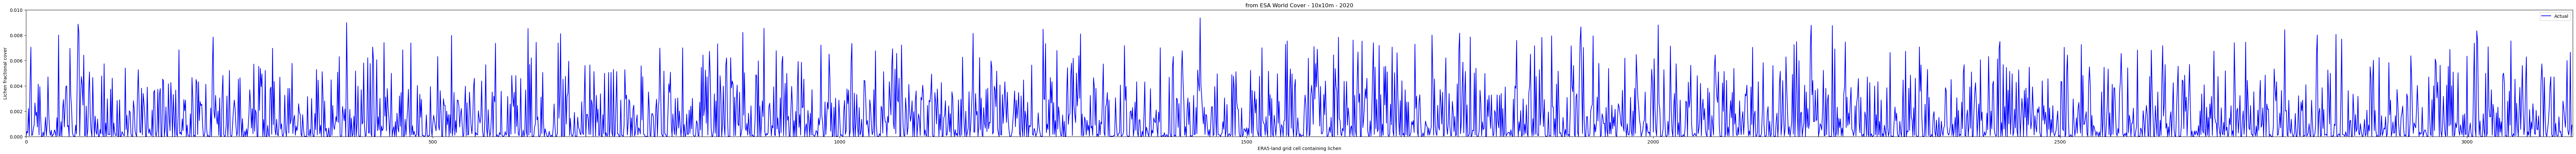

In [30]:
fig = plt.figure(figsize=(100, 5))
ax = fig.add_subplot(111)

plt.plot(dvy['Lichen_FC'], c = 'blue')

plt.ylabel('Lichen fractional cover')
plt.xlabel('ERA5-land grid cell containing lichen')
plt.title('from ESA World Cover - 10x10m - 2020')

plt.xlim(0., len(dvy))
plt.ylim(0., 0.01)
ax.legend(['Actual'])